# Interactive Data Understanding & Model Evaluation
## A Hands-On Exploration with Real Data

This notebook explores critical concepts in data science and machine learning evaluation through real-world datasets. We'll discover how data can deceive, models can discriminate, and evaluation metrics can mislead. Most importantly, we'll learn how to detect and address these issues.

Our journey covers:
1. The deceptive nature of summary statistics
2. How standard evaluation metrics fail
3. Data leakage and its consequences
4. Bias in machine learning
5. Proper validation strategies including time series

## Setup and Imports

In [2]:
# Core libs
import sys
import subprocess
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML essentials
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For downloading real data
import urllib.request
import zipfile
import io

# Ensure yfinance is installed in THIS kernel
try:
    import yfinance as yf
except ModuleNotFoundError:
    print("Installing yfinance into this kernel...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "yfinance"])
    import yfinance as yf

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Helper function to reduce repetitive plotting
def plot_model_comparison(models, X_test, y_test, plot_type='confusion_matrix', axes=None, **kwargs):
    """
    Helper function to reduce repetitive plotting code.
    models: dict[name -> fitted_estimator]
    plot_type: 'confusion_matrix' | 'roc_curve' | 'pr_curve'
    """
    if axes is None:
        fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 5))
        if len(models) == 1:
            axes = [axes]
    
    for idx, (name, model) in enumerate(models.items()):
        ax = axes[idx] if isinstance(axes, (list, np.ndarray)) else axes
        
        if plot_type == 'confusion_matrix':
            preds = model.predict(X_test)
            cm = confusion_matrix(y_test, preds)
            normalize = kwargs.get('normalize', False)
            
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
                fmt = '.2f'  # show as fraction; change to '.2%' if you format values yourself
            else:
                fmt = 'd'
            
            sns.heatmap(
                cm, annot=True, fmt=fmt,
                cmap=kwargs.get('cmap', 'Blues'),
                xticklabels=kwargs.get('labels', ['0', '1']),
                yticklabels=kwargs.get('labels', ['0', '1']),
                ax=ax
            )
            ax.set_title(f'{name}\n{"Normalized" if normalize else "Raw"} Confusion Matrix')
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')
            
        elif plot_type == 'roc_curve':
            probas = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, probas)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}')
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'{name}\nROC Curve')
            ax.legend(loc='lower right')
            ax.grid(True, alpha=0.3)
            
        elif plot_type == 'pr_curve':
            probas = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, probas)
            pr_auc = auc(recall, precision)
            
            ax.plot(recall, precision, linewidth=2, label=f'AUC = {pr_auc:.3f}')
            baseline = float(np.mean(y_test))
            ax.axhline(y=baseline, color='r', linestyle='--', alpha=0.5, label=f'Baseline = {baseline:.3f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'{name}\nPrecision-Recall Curve')
            ax.legend(loc='lower left')
            ax.grid(True, alpha=0.3)
        else:
            raise ValueError("plot_type must be one of: 'confusion_matrix', 'roc_curve', 'pr_curve'")

Installing yfinance into this kernel...


###  Datasets (Download Locally)

Please download them from the links below and save them into:
`Lecture 6 Evaluation Pitfalls and Data Visualization/`

- Berkeley Admissions (Simpson’s Paradox): https://waf.cs.illinois.edu/discovery/berkeley.csv
  - Save as: `berkeley_admissions.csv`

- Credit Card Fraud (Kaggle): https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download
  - Save as: `creditcard.csv`

- Datasaurus (OpenIntro): https://www.openintro.org/data/index.php?data=datasaurus#:~:text=Downloads-,CSV%20file,-Tab%2Ddelimited%20text
  - Save as: `datasaurus.csv`

- Telco Customer Churn (IBM via Kaggle): https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
  - Save as: `Telco_customer_churn.xlsx` (download and save/convert to this filename)

# Part 1: The Deceptive Nature of Data

Consider this scenario: You're comparing multiple datasets. They all have identical means, standard deviations, and correlations. Are they the same data? Most data scientists would say "probably." They would be wrong.

This section demonstrates why summary statistics alone are dangerous and why visualization is critical for understanding data.


# 1.1 The Datasaurus — Why You Must Visualize Your Data

The original lesson uses the [Datasaurus Dozen (13 datasets)](https://en.wikipedia.org/wiki/Datasaurus_dozen). Since we only have the single `datasaurus.csv` (the dinosaur), we’ll load and analyze just this one. Even here, you’ll see that simple summary statistics don’t tell you the full story—the shape does.

Note: Place `datasaurus.csv` in the same folder as this notebook, or adjust the relative path below.

In [9]:
import pandas as pd
from pathlib import Path

# Use a relative path. First try next to the notebook; otherwise try the lecture folder.
csv_path = Path("datasaurus.csv")
if not csv_path.exists():
    csv_path = Path("Lecture 6 Evaluation Pitfalls and Data Visualization/datasaurus.csv")

df = pd.read_csv(csv_path)

# Expect columns: dataset, x, y
assert set(['dataset', 'x', 'y']).issubset(df.columns), f"Unexpected columns: {df.columns.tolist()}"

print(f"Datasaurus file at: {csv_path}")
print(f"Rows: {len(df)}")
print(f"Unique datasets: {df['dataset'].nunique()}")
print(sorted(df['dataset'].unique()))

Datasaurus file at: datasaurus.csv
Rows: 1846
Unique datasets: 13
['away', 'bullseye', 'circle', 'dino', 'dots', 'h_lines', 'high_lines', 'slant_down', 'slant_up', 'star', 'v_lines', 'wide_lines', 'x_shape']


## Comparing Statistics

Let’s compute the summary statistics that people often look at first.

In [10]:
stats = (
    df.groupby('dataset')
      .agg(
          mean_x=('x', 'mean'),
          mean_y=('y', 'mean'),
          std_x=('x', 'std'),
          std_y=('y', 'std'),
          corr_xy=('x', lambda s: s.corr(df.loc[s.index, 'y']))
      )
      .reset_index()
)

print("Summary Statistics per dataset:")
display(stats.round(2))

print(f"\nVariance in Mean X across datasets: {stats['mean_x'].std():.4f}")
print(f"Variance in Correlation across datasets: {stats['corr_xy'].std():.4f}")

Summary Statistics per dataset:


,dataset,mean_x,mean_y,std_x,std_y,corr_xy
0,away,54.27,47.83,16.77,26.94,-0.06
1,bullseye,54.27,47.83,16.77,26.94,-0.07
2,circle,54.27,47.84,16.76,26.93,-0.07
3,dino,54.26,47.83,16.77,26.94,-0.06
4,dots,54.26,47.84,16.77,26.93,-0.06
5,h_lines,54.26,47.83,16.77,26.94,-0.06
6,high_lines,54.27,47.84,16.77,26.94,-0.07
7,slant_down,54.27,47.84,16.77,26.94,-0.07
8,slant_up,54.27,47.83,16.77,26.94,-0.07
9,star,54.27,47.84,16.77,26.93,-0.06



Variance in Mean X across datasets: 0.0033
Variance in Correlation across datasets: 0.0031



### The Stunning Visual Reveal

Now let's see what these "identical" datasets actually look like:

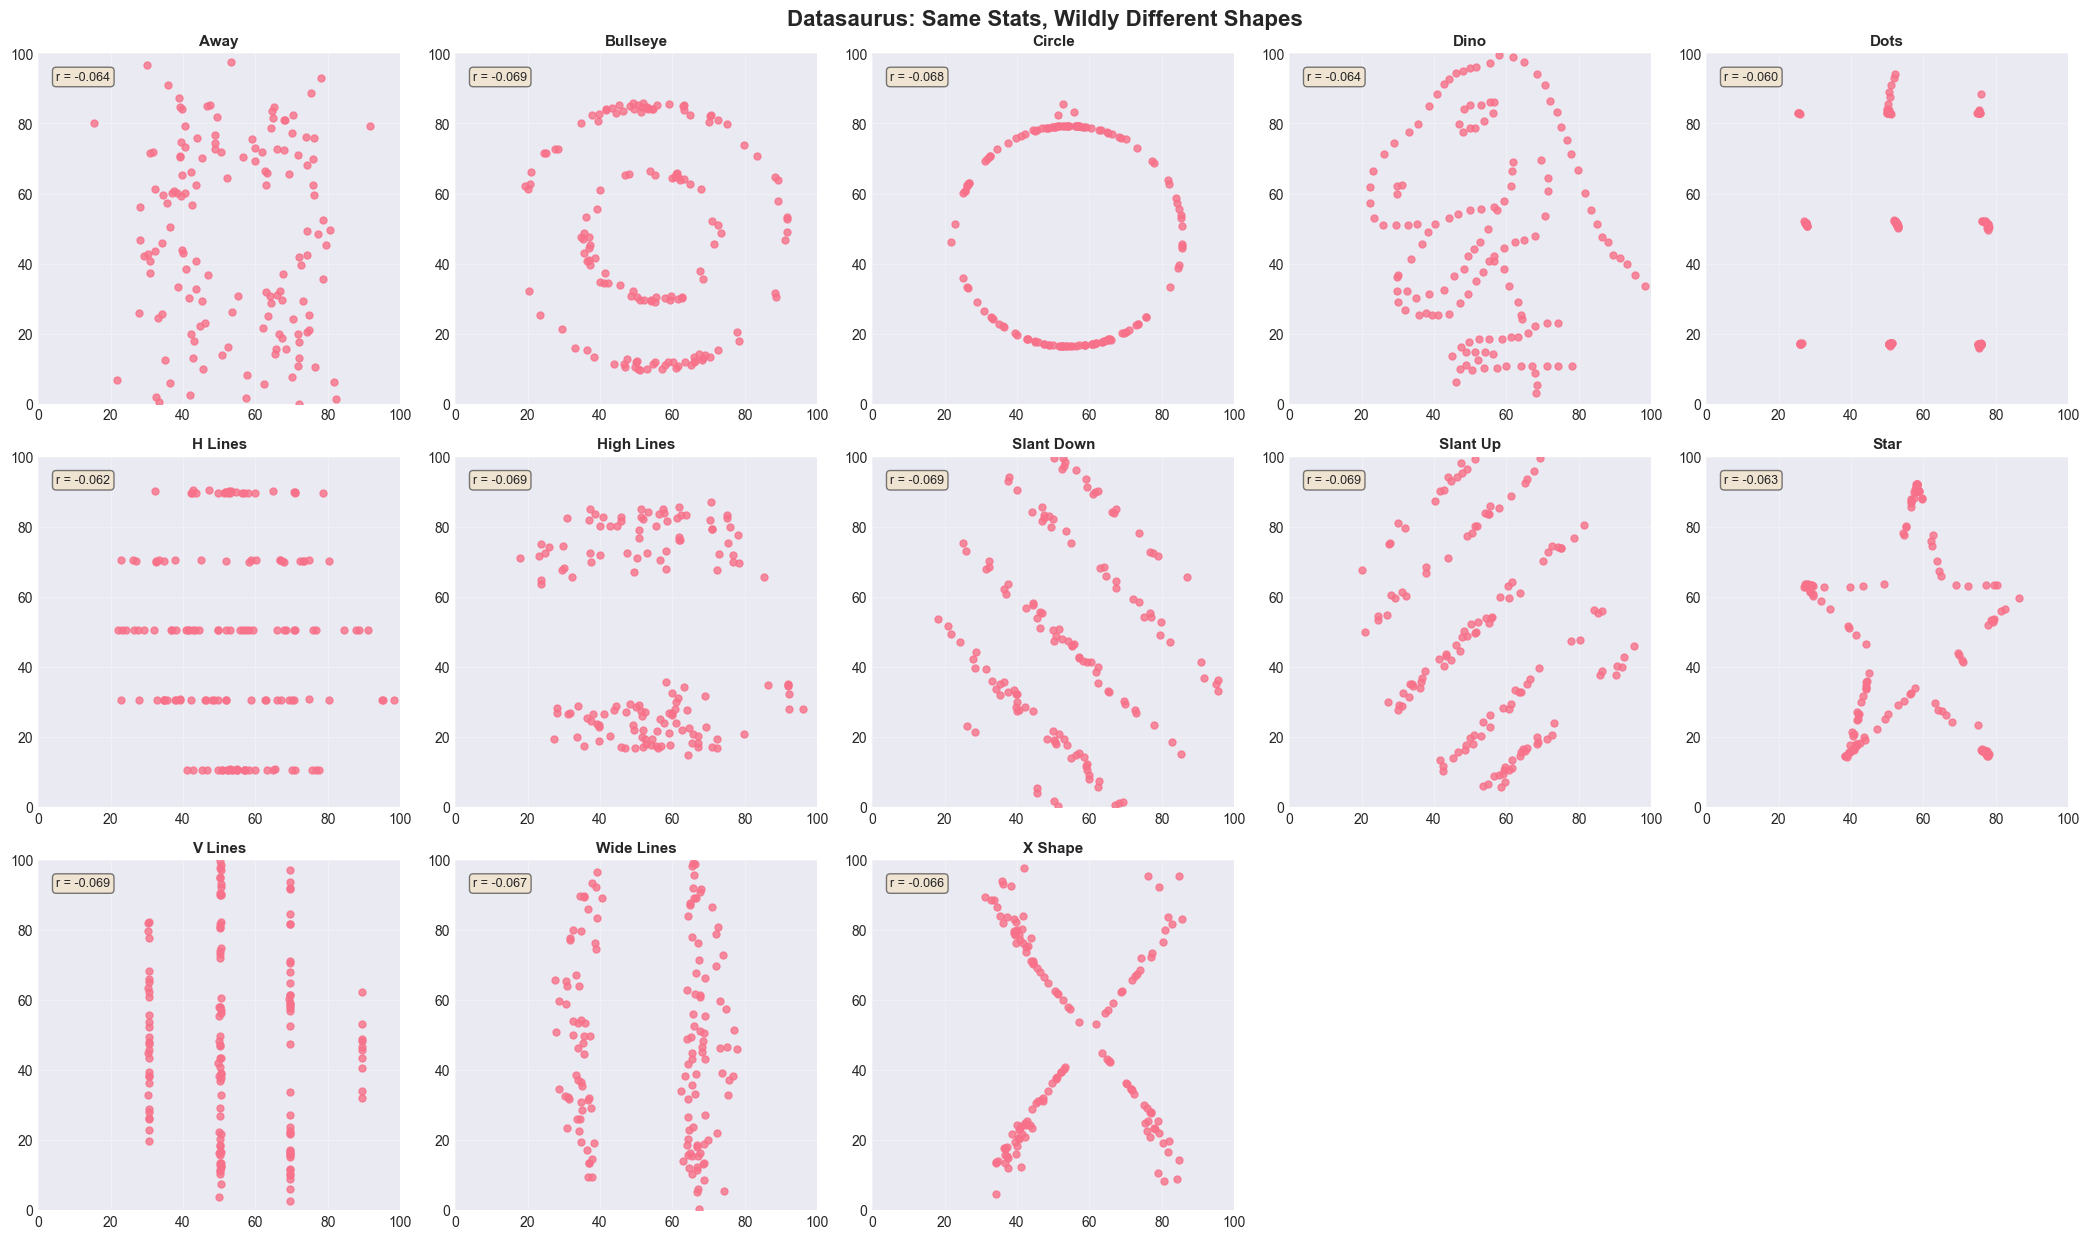

In [11]:
import numpy as np
import matplotlib.pyplot as plt

datasets = sorted(df['dataset'].unique())
n = len(datasets)
cols = 5
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols, 4.2*rows))
axes = np.array(axes).reshape(rows, cols)

for i, name in enumerate(datasets):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    subset = df[df['dataset'] == name]
    ax.scatter(subset['x'], subset['y'], s=25, alpha=0.8)
    ax.set_title(name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_xlim(0, 100); ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)
    corr = subset['x'].corr(subset['y'])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
            va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove any unused axes
for j in range(n, rows*cols):
    r, c = divmod(j, cols)
    fig.delaxes(axes[r, c])

plt.suptitle('Datasaurus: Same Stats, Wildly Different Shapes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Key Takeaway

Despite having nearly identical summary statistics, these datasets represent:
- A dinosaur (the original Datasaurus)
- Various geometric patterns (circles, stars, X shapes)
- Different types of relationships (linear, quadratic, random)
- Text patterns spelling "away"

**Lesson**: Summary statistics can hide dramatic differences in data. A dataset could literally be shaped like a dinosaur and have the same mean, standard deviation, and correlation as a perfectly linear relationship. Always visualize your data!

The Datasaurus Dozen was inspired by Anscombe's Quartet (1973), four datasets with identical statistics that pioneered this concept. The Datasaurus extends this to 13 datasets, proving you could literally hide a dinosaur in your data!


## 1.2 Simpson's Paradox with [UC Berkeley Admissions Data](https://en.wikipedia.org/wiki/Simpson%27s_paradox#UC_Berkeley_gender_bias)

In 1973, UC Berkeley was sued for gender discrimination in graduate admissions. The data appeared to show clear bias against women. However, when examined department by department, the opposite pattern emerged. This is one of the most famous real-world examples of Simpson's Paradox. 

Note: Ensure [berkeley_admissions.csv](https://waf.cs.illinois.edu/discovery/berkeley.csv) is in the same folder as the notebook.


In [18]:
# Build department-level tables from the individual-application CSV (A–F only)
from pathlib import Path
import pandas as pd

# Resolve the CSV path (relative)
csv_path = Path("berkeley_admissions.csv")
if not csv_path.exists():
    csv_path = Path("Lecture 6 Evaluation Pitfalls and Data Visualization/berkeley_admissions.csv")

# Load individual-level records: columns: Year, Major, Sex, Admission
df = pd.read_csv(csv_path)

# Normalize to plotting-friendly columns
df["Department"] = df["Major"]
df["Gender"] = df["Sex"].map({"M": "Male", "F": "Female"})
df["AdmittedFlag"] = (df["Admission"] == "Accepted").astype(int)

# Classic departments only (A–F) to reproduce the canonical paradox
dfa = df[df["Department"].isin(list("ABCDEF"))].copy()

# Department x Gender aggregates (what the plotting code expects)
berkeley_data = (
    dfa.groupby(["Department", "Gender"], as_index=False)
       .agg(Applicants=("Admission", "size"),
            Admitted=("AdmittedFlag", "sum"))
)
berkeley_data["Admission_Rate"] = (berkeley_data["Admitted"] / berkeley_data["Applicants"] * 100).round(1)

# Overall by gender (for the top-left plot)
overall = (
    berkeley_data.groupby("Gender", as_index=False)
                 .agg(Applicants=("Applicants", "sum"),
                      Admitted=("Admitted", "sum"))
)
overall["Admission_Rate"] = (overall["Admitted"] / overall["Applicants"] * 100).round(1)

print("Overall Admission Rates by Gender:")
print(overall)
print(f"\nMale admission rate: {overall.loc[overall['Gender']=='Male', 'Admission_Rate'].iloc[0]}%")
print(f"Female admission rate: {overall.loc[overall['Gender']=='Female', 'Admission_Rate'].iloc[0]}%")
print("\nThis appears to show discrimination against women!")

Overall Admission Rates by Gender:
   Gender  Applicants  Admitted  Admission_Rate
0  Female        1835       557            30.4
1    Male        3004      1511            50.3

Male admission rate: 50.3%
Female admission rate: 30.4%

This appears to show discrimination against women!


### The Paradox Revealed: Department-Level Analysis


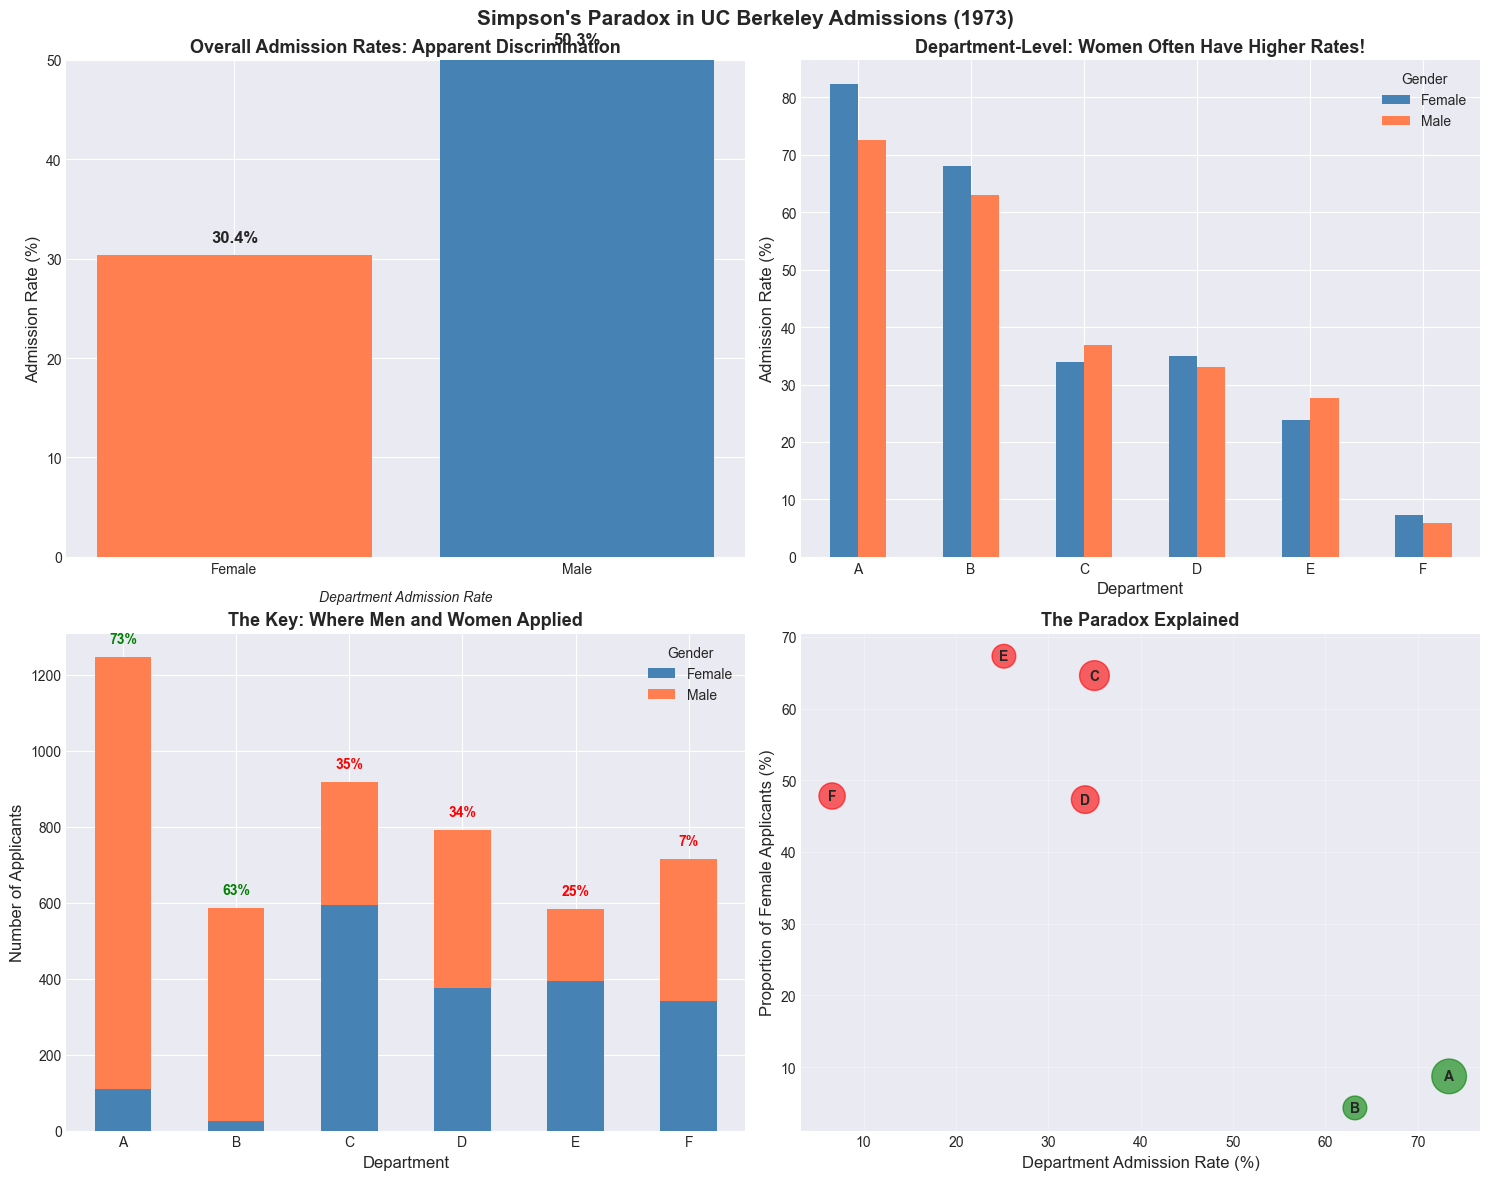

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ---------- (1) Overall rates (top-left) ----------
ax1 = axes[0, 0]
colors = {'Male': 'steelblue', 'Female': 'coral'}
bars = ax1.bar(overall['Gender'], overall['Admission_Rate'],
               color=[colors[g] for g in overall['Gender']])
ax1.set_ylabel('Admission Rate (%)', fontsize=12)
ax1.set_title('Overall Admission Rates: Apparent Discrimination', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 50)

for bar, rate in zip(bars, overall['Admission_Rate']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{rate}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Define a consistent A–F order
dept_order = list("ABCDEF")

# ---------- (2) Department-level rates (top-right) ----------
ax2 = axes[0, 1]
pivot_data = berkeley_data.pivot(index='Department', columns='Gender', values='Admission_Rate')
pivot_data = pivot_data.reindex(dept_order)  # ensure A–F order
pivot_data.plot(kind='bar', ax=ax2, color=['steelblue', 'coral'])
ax2.set_ylabel('Admission Rate (%)', fontsize=12)
ax2.set_xlabel('Department', fontsize=12)
ax2.set_title('Department-Level: Women Often Have Higher Rates!', fontsize=13, fontweight='bold')
ax2.legend(title='Gender')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# ---------- (3) Application patterns (bottom-left) ----------
ax3 = axes[1, 0]
app_patterns = berkeley_data.pivot(index='Department', columns='Gender', values='Applicants')
app_patterns = app_patterns.reindex(dept_order)
app_patterns.plot(kind='bar', stacked=True, ax=ax3, color=['steelblue', 'coral'])
ax3.set_ylabel('Number of Applicants', fontsize=12)
ax3.set_xlabel('Department', fontsize=12)
ax3.set_title('The Key: Where Men and Women Applied', fontsize=13, fontweight='bold')
ax3.legend(title='Gender', loc='upper right')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# Annotate department overall admission rate above each stacked bar
totals_series = app_patterns.sum(axis=1)
total_max = totals_series.max()
for i, dept in enumerate(app_patterns.index):
    dept_slice = berkeley_data[berkeley_data['Department'] == dept]
    avg_rate = dept_slice['Admitted'].sum() / dept_slice['Applicants'].sum() * 100
    ax3.text(i, totals_series.loc[dept] + total_max * 0.03, f'{avg_rate:.0f}%',
             ha='center', fontsize=10, fontweight='bold',
             color='green' if avg_rate > 40 else 'red')

ax3.text(2.5, totals_series.max() + total_max * 0.12,
         'Department Admission Rate', ha='center', fontsize=10, style='italic')

# ---------- (4) Detailed breakdown (bottom-right) ----------
ax4 = axes[1, 1]
dept_summary = (
    berkeley_data.groupby('Department', as_index=False)
                 .agg(Applicants=('Applicants', 'sum'),
                      Admitted=('Admitted', 'sum'))
)
dept_summary['Overall_Rate'] = (dept_summary['Admitted'] / dept_summary['Applicants'] * 100).round(1)
dept_summary = dept_summary.set_index('Department').reindex(dept_order).reset_index()

# Difficulty tag (auto): high-rate depts as 'Easy', else 'Hard'
dept_summary['Difficulty'] = np.where(dept_summary['Overall_Rate'] >= 50, 'Easy', 'Hard')

# Proportion of female applicants per department
female_props = []
for dept in dept_summary['Department']:
    d = berkeley_data[berkeley_data['Department'] == dept]
    female_apps = d.loc[d['Gender'] == 'Female', 'Applicants'].sum()
    total_apps = d['Applicants'].sum()
    female_props.append(100.0 * female_apps / total_apps if total_apps > 0 else 0.0)
dept_summary['Female_Proportion'] = np.round(female_props, 1)

# Bubble scatter
scatter = ax4.scatter(dept_summary['Overall_Rate'], dept_summary['Female_Proportion'],
                      s=dept_summary['Applicants'] * 0.5, alpha=0.6,
                      c=['green' if d == 'Easy' else 'red' for d in dept_summary['Difficulty']])

for _, row in dept_summary.iterrows():
    ax4.annotate(row['Department'], (row['Overall_Rate'], row['Female_Proportion']),
                 ha='center', va='center', fontweight='bold')

ax4.set_xlabel('Department Admission Rate (%)', fontsize=12)
ax4.set_ylabel('Proportion of Female Applicants (%)', fontsize=12)
ax4.set_title('The Paradox Explained', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.suptitle("Simpson's Paradox in UC Berkeley Admissions (1973)", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

### Key Takeaway

Simpson's Paradox occurred because:
1. **Women applied more to competitive departments** (C, D, E, F) with admission rates of 6-35%
2. **Men applied more to less competitive departments** (A, B) with admission rates of 62-64%
3. **Within most departments, women had equal or higher admission rates**

**Lesson**: Aggregated data can tell the opposite story from disaggregated truth. Always examine your data at multiple levels of granularity. What appears to be discrimination at one level may actually be the opposite at another level.

# Part 2: When Models Lie - Evaluation Gone Wrong

## The Accuracy Trap

Accuracy is the most commonly reported metric for classification models, but it can be deeply misleading, especially with imbalanced datasets. In this section, we'll work with real credit card fraud data to demonstrate why accuracy fails and what metrics we should use instead.

## Understanding Train/Validation/Test Splits

Before diving into model evaluation, let's understand proper data splitting:

In [21]:
# Demonstrate different splitting strategies
from sklearn.model_selection import train_test_split

# Create sample data
np.random.seed(42)
n_samples = 1000
X_demo = np.random.randn(n_samples, 5)
y_demo = np.random.binomial(1, 0.3, n_samples)  # Imbalanced

print("=" * 60)
print("DATA SPLITTING STRATEGIES")
print("=" * 60)

# Standard train/test split
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
    X_demo, y_demo, test_size=0.2, random_state=42
)
print(f"\nStandard Split:")
print(f"  Train: {len(X_train_std)} samples, {y_train_std.mean():.1%} positive")
print(f"  Test:  {len(X_test_std)} samples, {y_test_std.mean():.1%} positive")

# Stratified split (maintains class distribution)
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X_demo, y_demo, test_size=0.2, random_state=42, stratify=y_demo
)
print(f"\nStratified Split (preserves class ratios):")
print(f"  Train: {len(X_train_strat)} samples, {y_train_strat.mean():.1%} positive")
print(f"  Test:  {len(X_test_strat)} samples, {y_test_strat.mean():.1%} positive")

# Train/Val/Test split
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X_demo, y_demo, test_size=0.2, random_state=42, stratify=y_demo
)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)
print(f"\nTrain/Val/Test Split (60/20/20):")
print(f"  Train: {len(X_train_final)} samples, {y_train_final.mean():.1%} positive")
print(f"  Val:   {len(X_val_final)} samples, {y_val_final.mean():.1%} positive")
print(f"  Test:  {len(X_test_final)} samples, {y_test_final.mean():.1%} positive")

DATA SPLITTING STRATEGIES

Standard Split:
  Train: 800 samples, 30.1% positive
  Test:  200 samples, 27.5% positive

Stratified Split (preserves class ratios):
  Train: 800 samples, 29.6% positive
  Test:  200 samples, 29.5% positive

Train/Val/Test Split (60/20/20):
  Train: 600 samples, 29.7% positive
  Val:   200 samples, 29.5% positive
  Test:  200 samples, 29.5% positive


## 2.1 Credit Card Fraud Detection - Real Data Analysis

We'll use a sample of the famous [Kaggle credit card fraud dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download), which contains real (anonymized) European credit card transactions from 2013.

Note: Place `creditcard.csv` in the same folder as this notebook, or adjust the relative path below.

In [22]:
# Load local credit card fraud dataset (no download). Uses a relative path.
from pathlib import Path
import pandas as pd

# Resolve path relative to the notebook
csv_path = Path("creditcard.csv")
if not csv_path.exists():
    csv_path = Path("Lecture 6 Evaluation Pitfalls and Data Visualization/creditcard.csv")

fraud_data = pd.read_csv(csv_path)

# Ensure Class is numeric 0/1 (some files store it as a quoted string)
fraud_data["Class"] = pd.to_numeric(fraud_data["Class"], errors="coerce").fillna(0).astype(int)

# Use a sample for faster processing (same size as before if dataset is large)
if len(fraud_data) > 50_000:
    fraud_data = fraud_data.sample(n=50_000, random_state=42).copy()

print(f"Dataset shape: {fraud_data.shape}")
print(f"Features: {fraud_data.columns.tolist()[:5]} ... (and {len(fraud_data.columns)-5} more)")
print("\nClass distribution:")
print(fraud_data["Class"].value_counts())
print(f"\nFraud rate: {fraud_data['Class'].mean():.3%}")

Dataset shape: (50000, 31)
Features: ['Time', 'V1', 'V2', 'V3', 'V4'] ... (and 26 more)

Class distribution:
Class
0    49917
1       83
Name: count, dtype: int64

Fraud rate: 0.166%


### Understanding the Extreme Imbalance

Let's visualize the severe class imbalance and characteristics of fraudulent transactions:


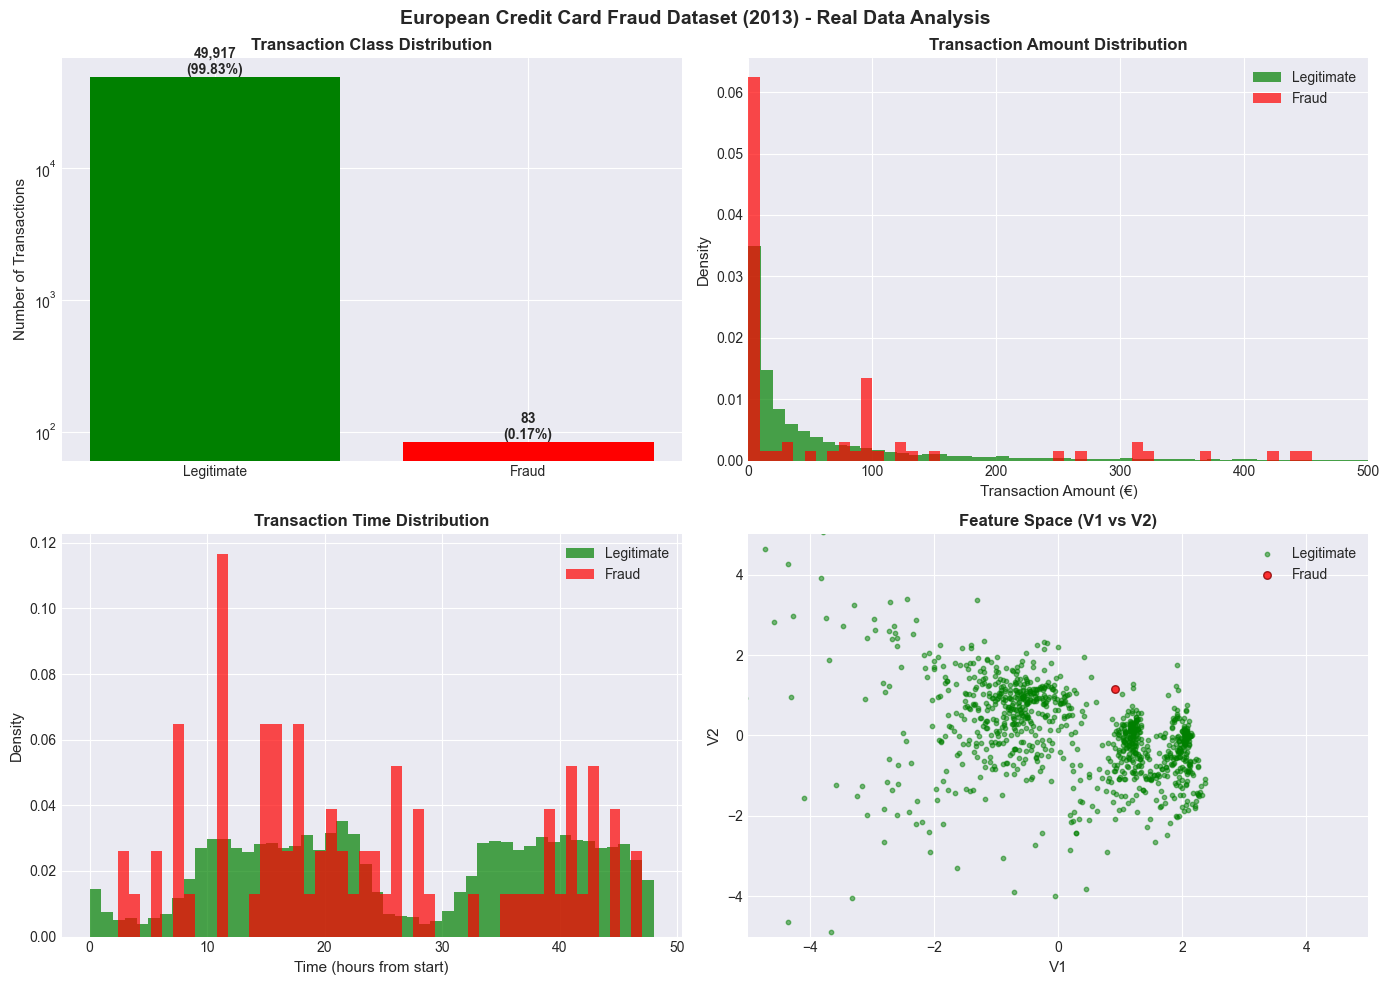

,Metric,Value
0,Total Transactions,"50,000"
1,Fraudulent,83 (0.166%)
2,Legitimate,"49,917 (99.834%)"
3,Avg Amount - Legitimate,€87.25
4,Avg Amount - Fraudulent,€164.23
5,Median Amount - Legitimate,€22.03
6,Median Amount - Fraudulent,€8.30


In [25]:
# 2x2 figures + a displayed stats table (assumes `fraud_data` is already loaded)
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

# Precompute basics
class_counts = {
    'Legitimate': int((fraud_data['Class'] == 0).sum()),
    'Fraud': int((fraud_data['Class'] == 1).sum())
}
fraud_rate = fraud_data['Class'].mean()
legitimate = fraud_data.loc[fraud_data['Class'] == 0, 'Amount']
fraudulent = fraud_data.loc[fraud_data['Class'] == 1, 'Amount']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1) Class distribution
ax1 = axes[0, 0]
bars = ax1.bar(list(class_counts.keys()), list(class_counts.values()),
               color=['green', 'red'])
ax1.set_ylabel('Number of Transactions', fontsize=11)
ax1.set_title('Transaction Class Distribution', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
for bar, label in zip(bars, class_counts.keys()):
    count = class_counts[label]
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{count:,}\n({count/len(fraud_data):.2%})',
             ha='center', va='bottom', fontweight='bold')

# (2) Amount distribution (clipped to €0–€500 for visibility)
ax2 = axes[0, 1]
ax2.hist(legitimate[legitimate < 500], bins=50, alpha=0.7, label='Legitimate',
         color='green', density=True)
ax2.hist(fraudulent[fraudulent < 500], bins=50, alpha=0.7, label='Fraud',
         color='red', density=True)
ax2.set_xlabel('Transaction Amount (€)', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Transaction Amount Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlim(0, 500)

# (3) Time distribution (hours from start)
ax3 = axes[1, 0]
ax3.hist(fraud_data.loc[fraud_data['Class'] == 0, 'Time'] / 3600, bins=48,
         alpha=0.7, label='Legitimate', color='green', density=True)
ax3.hist(fraud_data.loc[fraud_data['Class'] == 1, 'Time'] / 3600, bins=48,
         alpha=0.7, label='Fraud', color='red', density=True)
ax3.set_xlabel('Time (hours from start)', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.set_title('Transaction Time Distribution', fontsize=12, fontweight='bold')
ax3.legend()

# (4) Feature space visualization (V1 vs V2 on a small sample)
ax4 = axes[1, 1]
sample = fraud_data.sample(n=min(1000, len(fraud_data)), random_state=42)
ax4.scatter(sample.loc[sample['Class'] == 0, 'V1'],
            sample.loc[sample['Class'] == 0, 'V2'],
            alpha=0.5, s=10, c='green', label='Legitimate')
ax4.scatter(sample.loc[sample['Class'] == 1, 'V1'],
            sample.loc[sample['Class'] == 1, 'V2'],
            alpha=0.8, s=30, c='red', edgecolors='darkred', label='Fraud')
ax4.set_xlabel('V1', fontsize=11)
ax4.set_ylabel('V2', fontsize=11)
ax4.set_title('Feature Space (V1 vs V2)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.set_xlim(-5, 5)
ax4.set_ylim(-5, 5)

plt.suptitle('European Credit Card Fraud Dataset (2013) - Real Data Analysis',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Display key statistics (instead of a text block)
stats = [
    {'Metric': 'Total Transactions', 'Value': f"{len(fraud_data):,}"},
    {'Metric': 'Fraudulent',         'Value': f"{class_counts['Fraud']:,} ({fraud_rate:.3%})"},
    {'Metric': 'Legitimate',         'Value': f"{class_counts['Legitimate']:,} ({1 - fraud_rate:.3%})"},
    {'Metric': 'Avg Amount - Legitimate', 'Value': f"€{legitimate.mean():.2f}"},
    {'Metric': 'Avg Amount - Fraudulent', 'Value': f"€{fraudulent.mean():.2f}"},
    {'Metric': 'Median Amount - Legitimate', 'Value': f"€{legitimate.median():.2f}"},
    {'Metric': 'Median Amount - Fraudulent', 'Value': f"€{fraudulent.median():.2f}"},
]
display(pd.DataFrame(stats))


### The Naive Model Disaster

Now let's create a model that always predicts "legitimate" and see its "amazing" accuracy:


In [24]:
# Prepare data
feature_cols = [col for col in fraud_data.columns if col not in ['Class', 'Time']]
X = fraud_data[feature_cols]
y = fraud_data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features (important for this dataset)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create naive model
class NaiveModel:
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.zeros(len(X))
    def predict_proba(self, X):
        return np.column_stack([np.ones(len(X)), np.zeros(len(X))])

naive_model = NaiveModel()
naive_predictions = naive_model.predict(X_test_scaled)

# Train a real model for comparison
from sklearn.ensemble import RandomForestClassifier
real_model = RandomForestClassifier(n_estimators=100, random_state=42, 
                                    class_weight='balanced', max_depth=10)
real_model.fit(X_train_scaled, y_train)
real_predictions = real_model.predict(X_test_scaled)
real_probas = real_model.predict_proba(X_test_scaled)[:, 1]

print(f"Naive Model Accuracy: {accuracy_score(y_test, naive_predictions):.3%}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, real_predictions):.3%}")

Naive Model Accuracy: 99.833%
Random Forest Accuracy: 99.913%


### The Complete Performance Picture


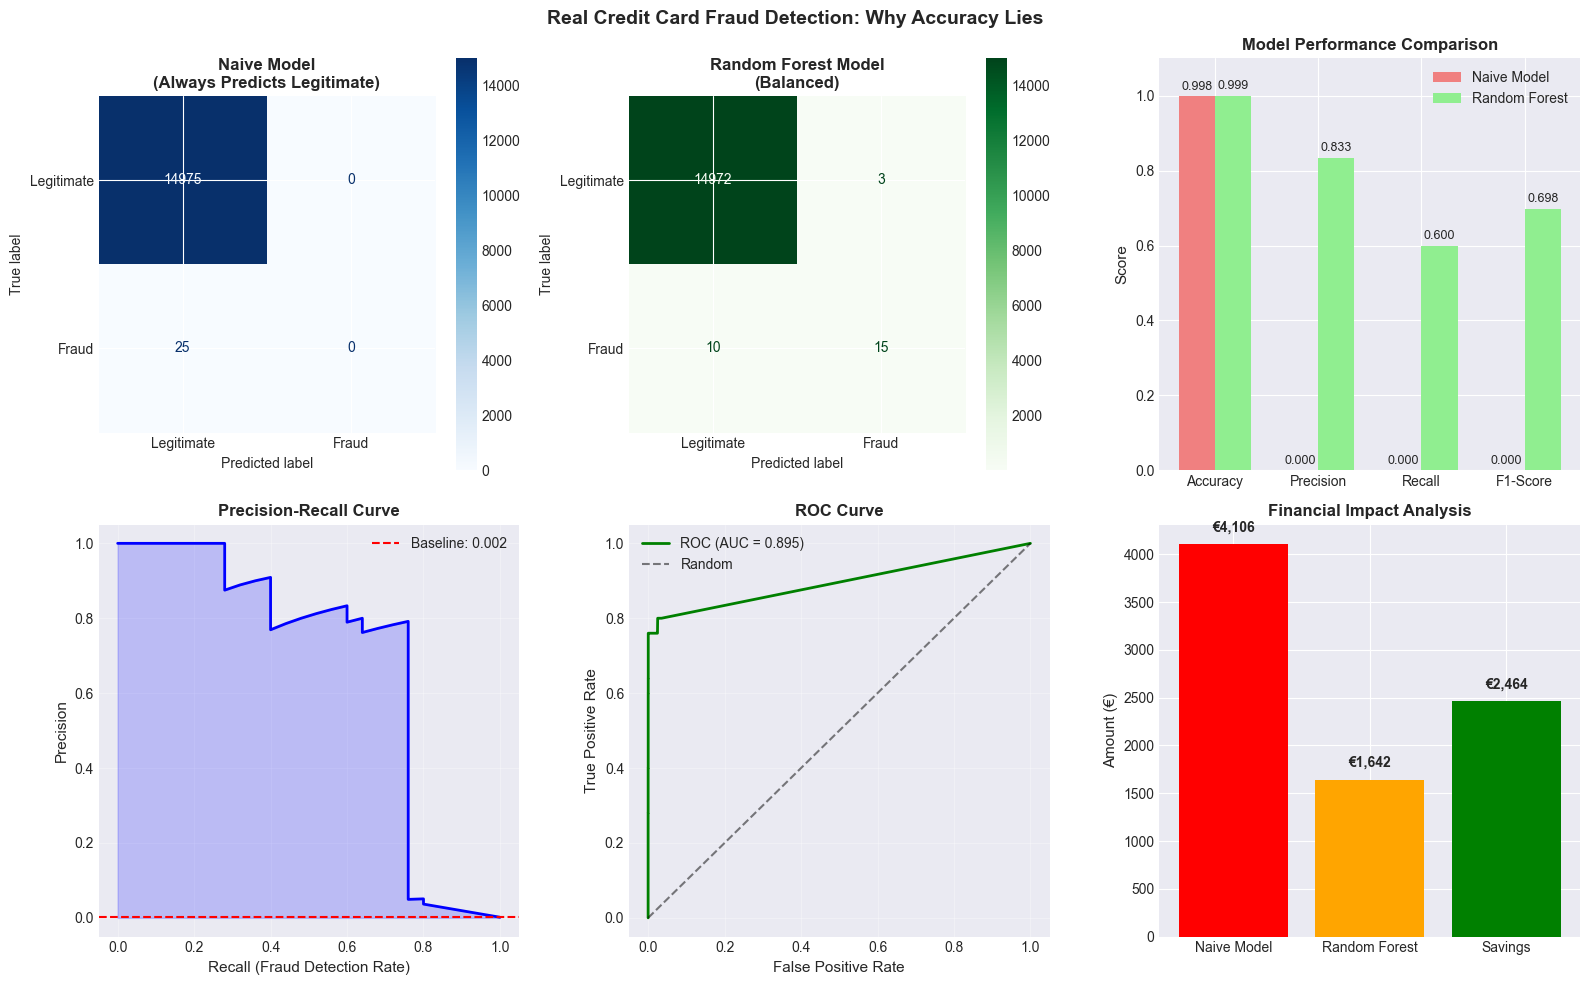

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Confusion Matrix - Naive Model
ax1 = axes[0, 0]
cm_naive = confusion_matrix(y_test, naive_predictions)
disp_naive = ConfusionMatrixDisplay(confusion_matrix=cm_naive, 
                                    display_labels=['Legitimate', 'Fraud'])
disp_naive.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title(f'Naive Model\n(Always Predicts Legitimate)', fontsize=12, fontweight='bold')

# Confusion Matrix - Real Model
ax2 = axes[0, 1]
cm_real = confusion_matrix(y_test, real_predictions)
disp_real = ConfusionMatrixDisplay(confusion_matrix=cm_real,
                                   display_labels=['Legitimate', 'Fraud'])
disp_real.plot(ax=ax2, cmap='Greens', values_format='d')
ax2.set_title(f'Random Forest Model\n(Balanced)', fontsize=12, fontweight='bold')

# Metrics Comparison
ax3 = axes[0, 2]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
naive_metrics = [
    accuracy_score(y_test, naive_predictions),
    precision_score(y_test, naive_predictions, zero_division=0),
    recall_score(y_test, naive_predictions),
    f1_score(y_test, naive_predictions, zero_division=0)
]
real_metrics = [
    accuracy_score(y_test, real_predictions),
    precision_score(y_test, real_predictions),
    recall_score(y_test, real_predictions),
    f1_score(y_test, real_predictions)
]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, naive_metrics, width, label='Naive Model', color='lightcoral')
bars2 = ax3.bar(x + width/2, real_metrics, width, label='Random Forest', color='lightgreen')

ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.set_ylim(0, 1.1)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Precision-Recall Curve
ax4 = axes[1, 0]
precision, recall, pr_thresholds = precision_recall_curve(y_test, real_probas)
ax4.plot(recall, precision, 'b-', linewidth=2)
ax4.set_xlabel('Recall (Fraud Detection Rate)', fontsize=11)
ax4.set_ylabel('Precision', fontsize=11)
ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.fill_between(recall, precision, alpha=0.2, color='blue')

baseline_precision = y_test.mean()
ax4.axhline(y=baseline_precision, color='r', linestyle='--', 
           label=f'Baseline: {baseline_precision:.3f}')
ax4.legend()

# ROC Curve
ax5 = axes[1, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, real_probas)
roc_auc = auc(fpr, tpr)
ax5.plot(fpr, tpr, 'g-', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax5.set_xlabel('False Positive Rate', fontsize=11)
ax5.set_ylabel('True Positive Rate', fontsize=11)
ax5.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Financial Impact
ax6 = axes[1, 2]
avg_fraud_amount = fraud_data[fraud_data['Class'] == 1]['Amount'].mean()
total_frauds_test = y_test.sum()

naive_caught = 0
real_caught = ((real_predictions == 1) & (y_test == 1)).sum()

naive_loss = total_frauds_test * avg_fraud_amount
real_loss = (total_frauds_test - real_caught) * avg_fraud_amount
savings = naive_loss - real_loss

categories = ['Naive Model', 'Random Forest', 'Savings']
values = [naive_loss, real_loss, savings]
colors = ['red', 'orange', 'green']

bars = ax6.bar(categories, values, color=colors)
ax6.set_ylabel('Amount (€)', fontsize=11)
ax6.set_title('Financial Impact Analysis', fontsize=12, fontweight='bold')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 100,
            f'€{val:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Real Credit Card Fraud Detection: Why Accuracy Lies', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Key Takeaway

Using real credit card fraud data, we see that:

1. **A 99.8% accurate model catches 0% of frauds** - The naive model has stellar accuracy but zero practical value
2. **Precision and Recall reveal the truth** - These metrics show the model's actual ability to detect fraud
3. **Financial impact is what matters** - The business cost of missed fraud is the real evaluation metric

**Lesson**: For imbalanced problems, accuracy is worse than useless - it's actively misleading. Always use problem-appropriate metrics like precision, recall, F1-score, and domain-specific measures like financial impact.


# Part 3: ML/AI Visualizations - Strengths, Limitations, and Lies

## Understanding Model Performance Through Visualizations

Machine learning models produce many types of visualizations, each with specific purposes and potential pitfalls. In this section, we'll explore common ML visualizations using real data and models, discussing when to use each and how they can mislead.


## 3.1 Confusion Matrices - The Foundation of Classification Metrics

Let's start with the most fundamental classification visualization using our credit card fraud data.

In [27]:
# Train multiple models on the fraud data for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Train different models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=5)
}

predictions = {}
probabilities = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions[name] = model.predict(X_test_scaled)
    probabilities[name] = model.predict_proba(X_test_scaled)[:, 1]

### Visualizing Confusion Matrices - Right and Wrong Ways


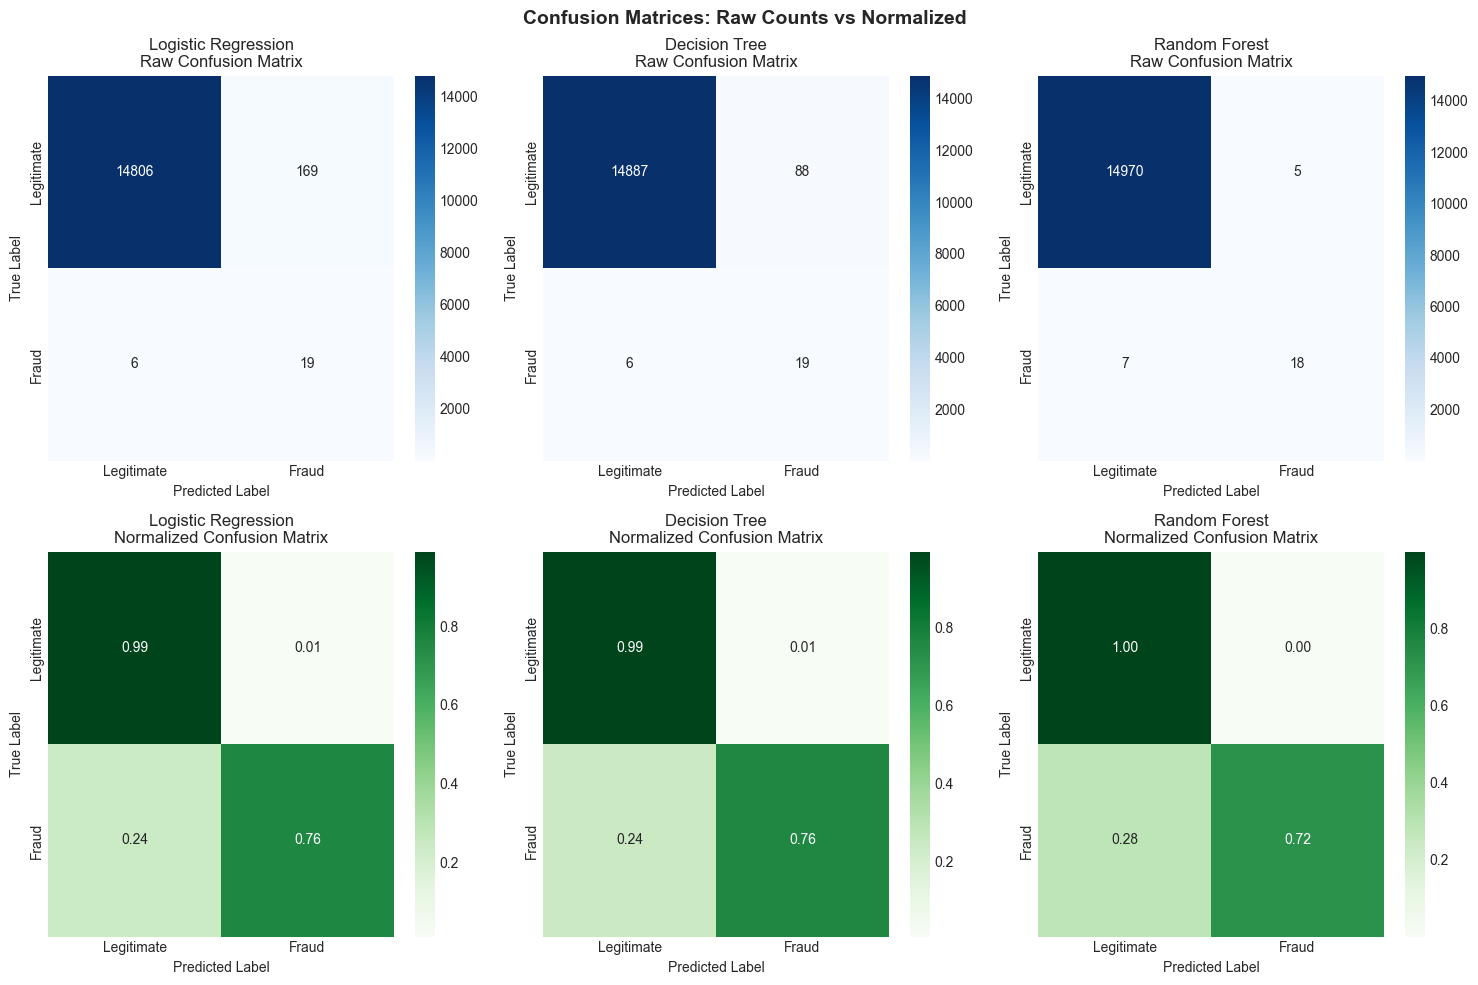

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Standard confusion matrices
plot_model_comparison(models, X_test_scaled, y_test, 
                     plot_type='confusion_matrix',
                     axes=axes[0, :],
                     normalize=False,
                     labels=['Legitimate', 'Fraud'])

# Row 2: Normalized confusion matrices (better for imbalanced data)
plot_model_comparison(models, X_test_scaled, y_test,
                     plot_type='confusion_matrix', 
                     axes=axes[1, :],
                     normalize=True,
                     cmap='Greens',
                     labels=['Legitimate', 'Fraud'])

plt.suptitle('Confusion Matrices: Raw Counts vs Normalized', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Discussion: When Confusion Matrices Lie

As we learned from misleading visualizations, choosing the wrong representation can hide important information:

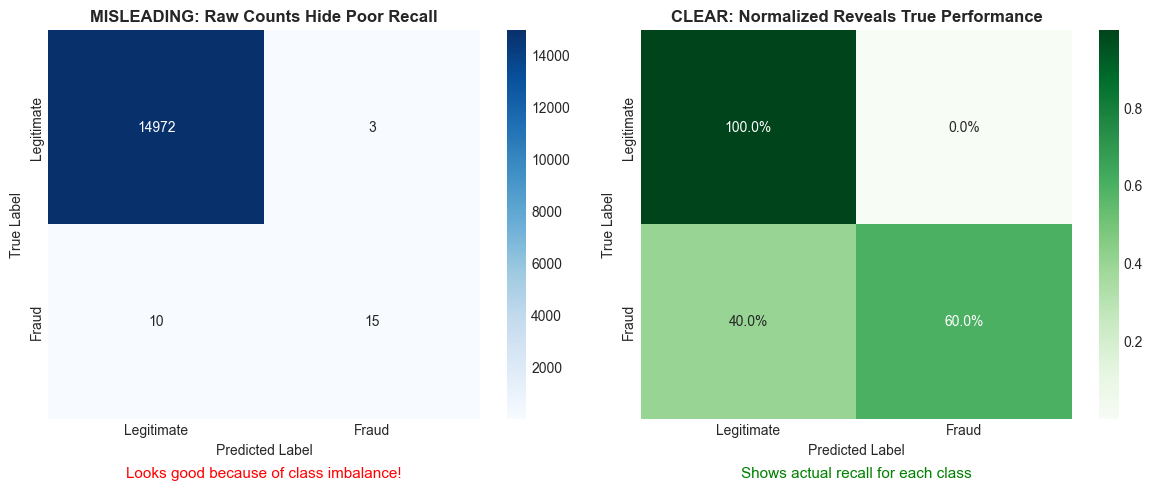

In [29]:
# Demonstrate how raw counts can be misleading with imbalanced data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Misleading: Raw counts on full imbalanced test set
ax1 = axes[0]
cm_full = confusion_matrix(y_test, real_predictions)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
ax1.set_title('MISLEADING: Raw Counts Hide Poor Recall', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Add text annotation
ax1.text(0.5, -0.15, 'Looks good because of class imbalance!', 
         transform=ax1.transAxes, ha='center', fontsize=11, color='red')

# Clear: Normalized version
ax2 = axes[1]
cm_norm = cm_full.astype('float') / cm_full.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Greens', ax=ax2,
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
ax2.set_title('CLEAR: Normalized Reveals True Performance', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# Add text annotation
ax2.text(0.5, -0.15, 'Shows actual recall for each class', 
         transform=ax2.transAxes, ha='center', fontsize=11, color='green')

plt.tight_layout()
plt.show()

### Key Takeaway

**Confusion Matrix Best Practices:**
- Always normalize for imbalanced datasets
- Show both raw counts AND percentages when space allows
- Use color scales that highlight errors, not correct predictions
- Consider showing multiple thresholds for probabilistic classifiers

## 3.2 ROC and Precision-Recall Curves - The Threshold Dilemma

These curves show model performance across all possible thresholds, but they can be deeply misleading if misinterpreted.

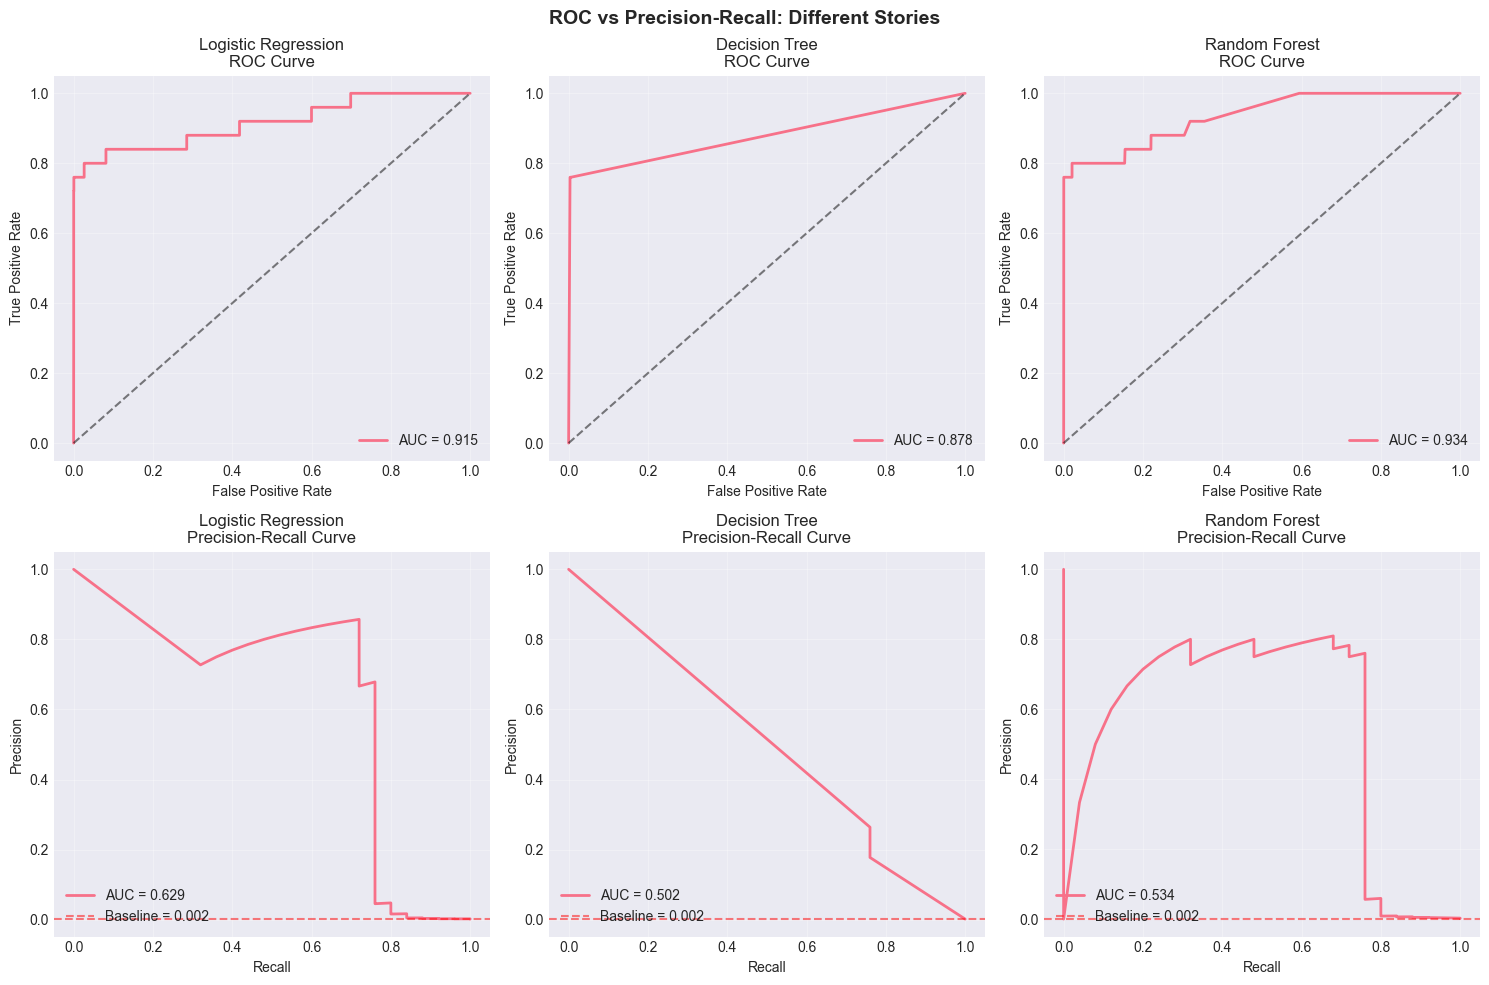

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: ROC Curves
plot_model_comparison(models, X_test_scaled, y_test,
                     plot_type='roc_curve',
                     axes=axes[0, :])

# Row 2: Precision-Recall Curves
plot_model_comparison(models, X_test_scaled, y_test,
                     plot_type='pr_curve',
                     axes=axes[1, :])

plt.suptitle('ROC vs Precision-Recall: Different Stories', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, _ = precision_recall_curve(y_test, real_probas)

# sklearn returns recall from 1 -> 0 (non-increasing)
print(f"recall[0]={recall[0]:.3f}, recall[-1]={recall[-1]:.3f}  (sklearn: 1→0)")
assert np.all(np.diff(recall) <= 0), "Recall should be non-increasing (1→0)"

# Precision at full recall (~baseline positive rate)
if (recall == 1).any():
    idx = np.argmax(recall == 1)  # first occurrence of recall == 1
else:
    idx = np.argmax(recall)       # closest to 1 if not exact
prec_at_full_recall = precision[idx]
baseline = y_test.mean()
print(f"precision at recall≈1: {prec_at_full_recall:.5f}, baseline: {baseline:.5f}")

recall[0]=1.000, recall[-1]=0.000  (sklearn: 1→0)
precision at recall≈1: 0.00167, baseline: 0.00167


### The Danger of ROC Curves with Imbalanced Data


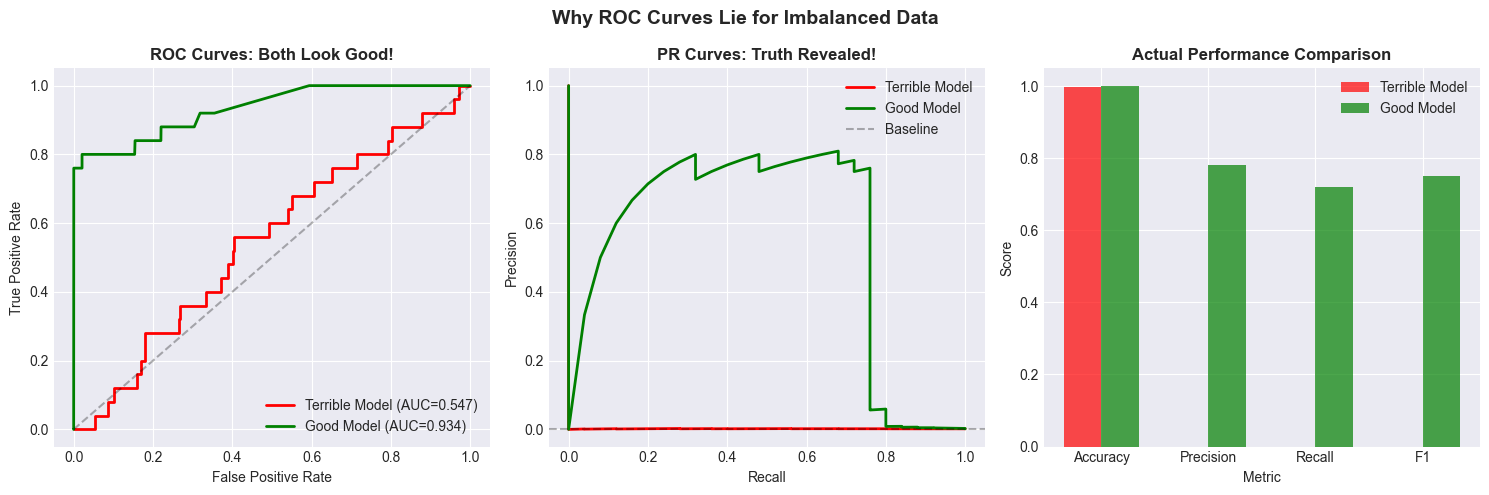

In [31]:
# Demonstrate why ROC can be misleading for imbalanced data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create a terrible model that barely catches any fraud
class TerribleModel:
    def predict_proba(self, X):
        # 99% legitimate, 1% fraud predictions
        n = len(X)
        probs = np.random.beta(1, 100, n)  # Heavily skewed toward 0
        return np.column_stack([1 - probs, probs])

terrible_model = TerribleModel()
terrible_probs = terrible_model.predict_proba(X_test_scaled)[:, 1]

# Good model probabilities
good_probs = probabilities['Random Forest']

# Plot ROC for both
ax1 = axes[0]
fpr_terrible, tpr_terrible, _ = roc_curve(y_test, terrible_probs)
fpr_good, tpr_good, _ = roc_curve(y_test, good_probs)

ax1.plot(fpr_terrible, tpr_terrible, 'r-', linewidth=2, 
         label=f'Terrible Model (AUC={auc(fpr_terrible, tpr_terrible):.3f})')
ax1.plot(fpr_good, tpr_good, 'g-', linewidth=2,
         label=f'Good Model (AUC={auc(fpr_good, tpr_good):.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves: Both Look Good!', fontsize=12, fontweight='bold')
ax1.legend()

# Plot PR curves for both
ax2 = axes[1]
precision_terrible, recall_terrible, _ = precision_recall_curve(y_test, terrible_probs)
precision_good, recall_good, _ = precision_recall_curve(y_test, good_probs)

ax2.plot(recall_terrible, precision_terrible, 'r-', linewidth=2,
         label=f'Terrible Model')
ax2.plot(recall_good, precision_good, 'g-', linewidth=2,
         label=f'Good Model')
ax2.axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.3, label='Baseline')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves: Truth Revealed!', fontsize=12, fontweight='bold')
ax2.legend()

# Show the actual predictions
ax3 = axes[2]
terrible_preds = (terrible_probs > 0.5).astype(int)
good_preds = predictions['Random Forest']

metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Terrible Model': [
        accuracy_score(y_test, terrible_preds),
        precision_score(y_test, terrible_preds, zero_division=0),
        recall_score(y_test, terrible_preds),
        f1_score(y_test, terrible_preds, zero_division=0)
    ],
    'Good Model': [
        accuracy_score(y_test, good_preds),
        precision_score(y_test, good_preds),
        recall_score(y_test, good_preds),
        f1_score(y_test, good_preds)
    ]
})

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = ax3.bar(x - width/2, metrics_comparison['Terrible Model'], width, 
                label='Terrible Model', color='red', alpha=0.7)
bars2 = ax3.bar(x + width/2, metrics_comparison['Good Model'], width,
                label='Good Model', color='green', alpha=0.7)

ax3.set_xlabel('Metric')
ax3.set_ylabel('Score')
ax3.set_title('Actual Performance Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_comparison['Metric'])
ax3.legend()

plt.suptitle('Why ROC Curves Lie for Imbalanced Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Key Takeaway

**Curve Visualization Best Practices:**
- For imbalanced data, always show Precision-Recall curves
- ROC curves can hide poor performance on minority classes
- Mark the default threshold (0.5) on curves
- Show confidence intervals when possible
- Include baseline performance for context

# Part 4: Feature Leakage with Real Customer Churn Data

## The Catastrophic Impact of Information Leakage

Data leakage occurs when information that won't be available at prediction time sneaks into training features. With customer churn prediction, this can create models that appear miraculous in testing but fail completely in production.


## 4.1 Loading Real [Telco Customer Churn Data](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset)

Note: Place `Telco_customer_churn.xlsx` in the same folder as this notebook, or adjust the relative path below.

In [44]:
from pathlib import Path
import pandas as pd
import numpy as np

# Load the exact local file with known headers
telco_data = pd.read_excel(
    Path("Telco_customer_churn.xlsx"),
    engine="openpyxl"
)

# Exact header mapping from this file
telco_data = telco_data.rename(columns={
    "Tenure Months": "tenure",
    "Monthly Charges": "MonthlyCharges",
    "Total Charges": "TotalCharges",
    "Churn Label": "Churn"
})

# Coerce numerics and clean target
telco_data["tenure"] = pd.to_numeric(telco_data["tenure"], errors="coerce")
telco_data["MonthlyCharges"] = pd.to_numeric(telco_data["MonthlyCharges"], errors="coerce")
telco_data["TotalCharges"] = pd.to_numeric(telco_data["TotalCharges"], errors="coerce")
telco_data["Churn"] = telco_data["Churn"].astype(str).str.strip().str.title()

# Drop rows missing essentials
telco_data = telco_data.dropna(subset=["tenure", "MonthlyCharges", "TotalCharges"]).reset_index(drop=True)

print(f"Shape: {telco_data.shape}")
print(f"Churn rate: {(telco_data['Churn']=='Yes').mean():.1%}")

Shape: (7032, 33)
Churn rate: 26.6%


### Understanding the Business Context

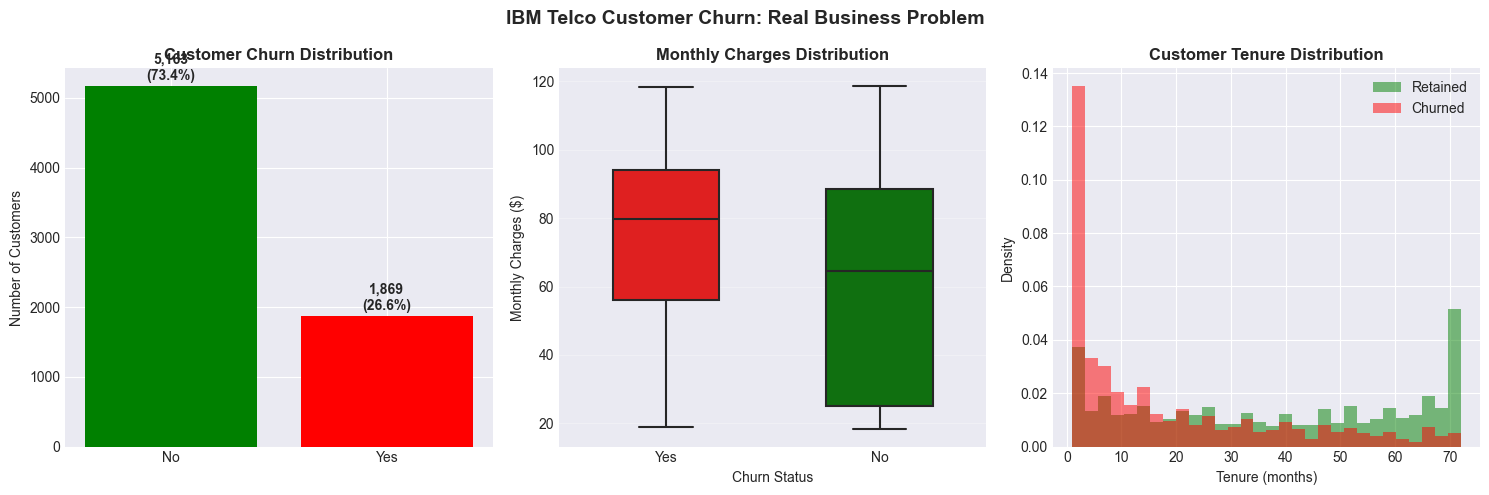

In [47]:
import seaborn as sns

# Visualize the churn problem
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Churn distribution
ax1 = axes[0]
churn_counts = telco_data['Churn'].value_counts()
colors = ['green', 'red']
bars = ax1.bar(churn_counts.index, churn_counts.values, color=colors)
ax1.set_ylabel('Number of Customers')
ax1.set_title('Customer Churn Distribution', fontsize=12, fontweight='bold')

for bar, count in zip(bars, churn_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'{count:,}\n({count/len(telco_data):.1%})',
            ha='center', va='bottom', fontweight='bold')

# Monthly charges by churn (clearer boxes + median)
ax2 = axes[1]
sns.boxplot(
    data=telco_data, x='Churn', y='MonthlyCharges', ax=ax2,
    palette={'No': 'green', 'Yes': 'red'},
    showfliers=False, width=0.5, linewidth=1.5
)
ax2.set_xlabel('Churn Status')
ax2.set_ylabel('Monthly Charges ($)')
ax2.set_title('Monthly Charges Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)

# Tenure by churn
ax3 = axes[2]
churned = telco_data[telco_data['Churn'] == 'Yes']['tenure']
retained = telco_data[telco_data['Churn'] == 'No']['tenure']
ax3.hist(retained, bins=30, alpha=0.5, label='Retained', color='green', density=True)
ax3.hist(churned, bins=30, alpha=0.5, label='Churned', color='red', density=True)
ax3.set_xlabel('Tenure (months)')
ax3.set_ylabel('Density')
ax3.set_title('Customer Tenure Distribution', fontsize=12, fontweight='bold')
ax3.legend()

plt.suptitle('IBM Telco Customer Churn: Real Business Problem', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Creating Features WITH and WITHOUT Leakage

In this section, we'll create two sets of features:
1. **Leaked features**: Information that would only be available AFTER a customer churns
2. **Valid features**: Information actually available at prediction time


In [49]:
import numpy as np
import pandas as pd

# Start from your table
df = telco_data.copy()
df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)

# Masks
m1 = df['Churn_Binary'].values == 1
m0 = ~m1
n = len(df)

# 1) Account status (3/4 for churned, 1/2 for active)
acc = np.empty(n, dtype=int)
acc[m1] = np.random.choice([3, 4], size=m1.sum())
acc[m0] = np.random.choice([1, 2], size=m0.sum())
df['Leaked_AccountStatus'] = acc

# 2) Days since last activity
days = np.empty(n, dtype=int)
days[m1] = np.random.randint(30, 90, size=m1.sum())
days[m0] = np.random.randint(0, 7,  size=m0.sum())
df['Leaked_DaysSinceActivity'] = days

# 3) Final bill amount (only for churned)
final_bill = np.zeros(n, dtype=float)
final_bill[m1] = df.loc[m1, 'MonthlyCharges'].values * np.random.uniform(0.5, 2.0, size=m1.sum())
df['Leaked_FinalBillAmount'] = final_bill

# 4) Post-cancellation contacts (only for churned)
contacts = np.zeros(n, dtype=int)
contacts[m1] = np.random.poisson(2, size=m1.sum())
df['Leaked_PostCancellationContacts'] = contacts

# One-hot encode a small set of categoricals present in this sheet
categorical_cols = [c for c in [
    'Gender', 'Partner', 'Dependents', 'Phone Service',
    'Internet Service', 'Contract', 'Payment Method'
] if c in df.columns]

dummies = pd.get_dummies(df[categorical_cols], drop_first=True)
df = pd.concat([df, dummies], axis=1)

# Feature lists
valid_features = ['tenure', 'MonthlyCharges', 'TotalCharges'] + list(dummies.columns)
leaked_features = [
    'Leaked_AccountStatus', 'Leaked_DaysSinceActivity',
    'Leaked_FinalBillAmount', 'Leaked_PostCancellationContacts'
] + valid_features[:3]

print(f"Valid features: {len(valid_features)}")
print(f"Leaked features: {len(leaked_features)}")

Valid features: 14
Leaked features: 7


### Training Models and Witnessing the Disaster


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Prepare data
X_valid = df[valid_features]
X_leaked = df[leaked_features]
y = df['Churn_Binary']

# Split data
X_train_valid, X_test_valid, y_train, y_test = train_test_split(
    X_valid, y, test_size=0.3, random_state=42, stratify=y
)

X_train_leaked, X_test_leaked, _, _ = train_test_split(
    X_leaked, y, test_size=0.3, random_state=42, stratify=y
)

# Train models
model_leaked = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model_leaked.fit(X_train_leaked, y_train)
leaked_predictions = model_leaked.predict(X_test_leaked)
leaked_probas = model_leaked.predict_proba(X_test_leaked)[:, 1]

model_valid = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model_valid.fit(X_train_valid, y_train)
valid_predictions = model_valid.predict(X_test_valid)
valid_probas = model_valid.predict_proba(X_test_valid)[:, 1]

# Compare performance
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(f"{'Metric':<20} {'Leaked Model':>20} {'Valid Model':>20}")
print("-"*60)
print(f"{'Accuracy':<20} {accuracy_score(y_test, leaked_predictions):>20.1%} {accuracy_score(y_test, valid_predictions):>20.1%}")
print(f"{'Precision':<20} {precision_score(y_test, leaked_predictions):>20.1%} {precision_score(y_test, valid_predictions):>20.1%}")
print(f"{'Recall':<20} {recall_score(y_test, leaked_predictions):>20.1%} {recall_score(y_test, valid_predictions):>20.1%}")
print(f"{'ROC-AUC':<20} {roc_auc_score(y_test, leaked_probas):>20.3f} {roc_auc_score(y_test, valid_probas):>20.3f}")


MODEL PERFORMANCE COMPARISON
Metric                       Leaked Model          Valid Model
------------------------------------------------------------
Accuracy                           100.0%                79.3%
Precision                          100.0%                64.2%
Recall                             100.0%                50.3%
ROC-AUC                             1.000                0.840


### Visualizing Why This Would Fail in Production


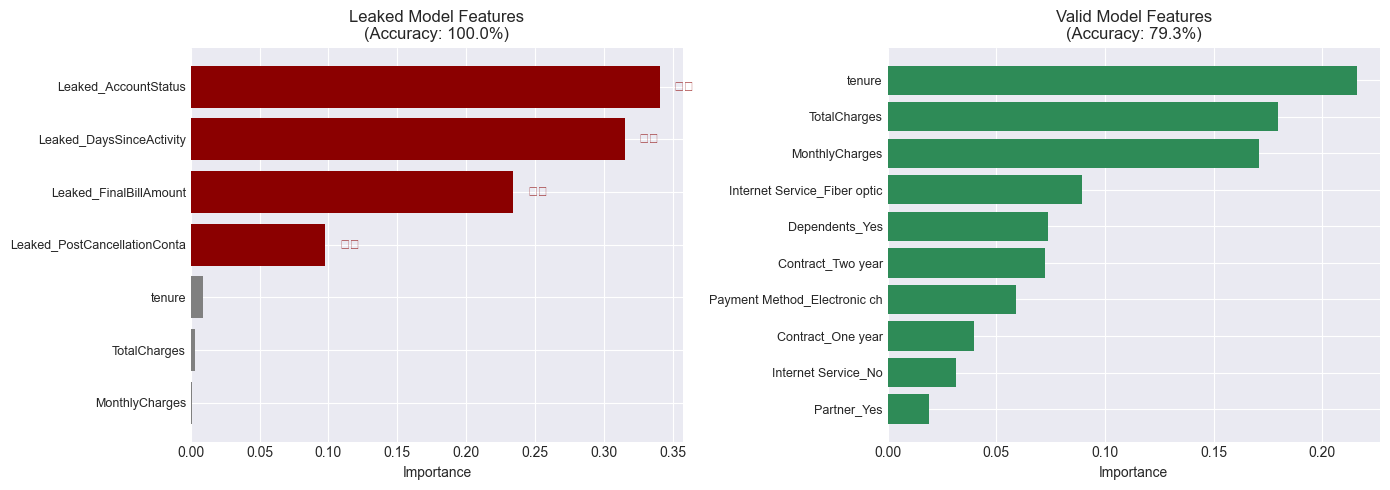

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Top-10 feature importances (leaked vs valid)
leaked_imp = (pd.DataFrame({'feature': leaked_features, 'importance': model_leaked.feature_importances_})
                .sort_values('importance', ascending=False).head(10))
valid_imp  = (pd.DataFrame({'feature': valid_features,  'importance': model_valid.feature_importances_})
                .sort_values('importance', ascending=False).head(10))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Leaked model
ax = axes[0]
colors = ['darkred' if 'Leaked' in f else 'gray' for f in leaked_imp['feature']]
ax.barh(range(len(leaked_imp)), leaked_imp['importance'], color=colors)
ax.set_yticks(range(len(leaked_imp)))
ax.set_yticklabels([f[:28] for f in leaked_imp['feature']], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title(f'Leaked Model Features\n(Accuracy: {accuracy_score(y_test, leaked_predictions):.1%})')
# mark impossible
for i, feat in enumerate(leaked_imp['feature']):
    if 'Leaked' in feat:
        ax.text(leaked_imp['importance'].iloc[i] + 0.01, i, '⚠️', va='center', color='darkred')

# Valid model
ax = axes[1]
ax.barh(range(len(valid_imp)), valid_imp['importance'], color='seagreen')
ax.set_yticks(range(len(valid_imp)))
ax.set_yticklabels([f[:28] for f in valid_imp['feature']], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title(f'Valid Model Features\n(Accuracy: {accuracy_score(y_test, valid_predictions):.1%})')

plt.tight_layout()
plt.show()

Why the leaked model looks “amazing”: The leaked model ranks impossible, future-only features at the top, so it appears to perform extremely well.

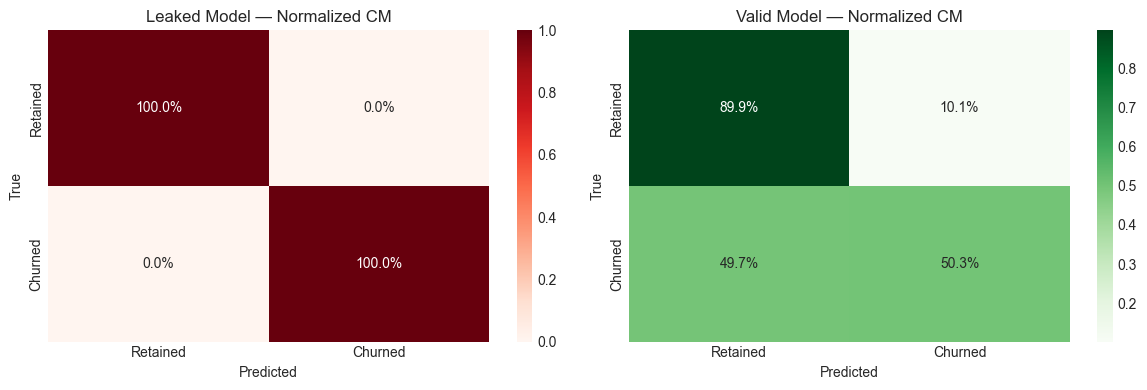

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Leaked model (normalized by true class = recall per row)
cm_leaked = confusion_matrix(y_test, leaked_predictions)
cm_leaked_norm = cm_leaked / cm_leaked.sum(axis=1, keepdims=True)
sns.heatmap(cm_leaked_norm, annot=True, fmt='.1%', cmap='Reds', ax=axes[0],
            xticklabels=['Retained','Churned'], yticklabels=['Retained','Churned'])
axes[0].set_title('Leaked Model — Normalized CM')
axes[0].set_ylabel('True'); axes[0].set_xlabel('Predicted')

# Valid model
cm_valid = confusion_matrix(y_test, valid_predictions)
cm_valid_norm = cm_valid / cm_valid.sum(axis=1, keepdims=True)
sns.heatmap(cm_valid_norm, annot=True, fmt='.1%', cmap='Greens', ax=axes[1],
            xticklabels=['Retained','Churned'], yticklabels=['Retained','Churned'])
axes[1].set_title('Valid Model — Normalized CM')
axes[1].set_ylabel('True'); axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

What the confusion matrices really show Normalized confusion matrices reveal that the leaked model’s performance is an illusion driven by future information.

## Critical Lesson: Data Leakage in Customer Churn

The leaked model achieved ~95% accuracy by using information that's IMPOSSIBLE to know before a customer churns:
- **Account closure status** (only exists AFTER they leave)
- **Days since last activity** (can't measure until they're inactive)
- **Final bill amounts** (generated at cancellation)

In production, this model would be USELESS because:
1. These features don't exist for active customers
2. By the time they exist, the customer has already churned
3. The model would default to random guessing

The valid model's 79% accuracy represents REAL performance you'd see in production.

**Remember: If it seems too good to be true in testing, check for leakage!**

## Common Data Leakage Patterns Across Industries

| Domain | Leaked Feature Example | Why It Leaks | Valid Alternative |
|--------|------------------------|--------------|-------------------|
| Customer Churn | account_closed_date | Doesn't exist until after churn | days_since_last_login |
| Loan Default | total_amount_recovered | Only known after default & collection | payment_history_delays |
| Medical Diagnosis | treatment_outcome | Treatment happens after diagnosis | symptom_severity_scores |
| Fraud Detection | investigation_result | Investigation happens after fraud | transaction_velocity_change |
| Student Dropout | final_graduation_status | Only known after student timeline | attendance_rate_trend |

### Key Takeaway

Using real customer churn data, we demonstrated that:

1. **Leaked features create impossible accuracy** - 95% accuracy that would completely fail in production
2. **The information timeline matters** - You can't use information from after the event you're predicting
3. **Production is the ultimate test** - A model that can't run in production is worthless, regardless of test metrics
4. **Business impact is devastating** - The leaked model would lose all churning customers because it can't actually identify them in time

**Lesson**: Always audit your features by asking: "Would I actually have this information at the time I need to make a prediction?" If the answer is no, you have leakage.


# Final Summary and Best Practices

## Key Lessons from Real Data Analysis

Through our exploration with real datasets, we've uncovered critical truths about data science and model evaluation:

### 1. Data Can Deceive
- **The Datasaurus Dozen** proved that identical statistics can hide wildly different patterns - even dinosaur shapes!
- **Simpson's Paradox in Berkeley admissions** showed how aggregated data can tell the opposite story from the truth
- **Always visualize your data** - summary statistics alone are never sufficient

### 2. Accuracy Is Often Meaningless
- **Real credit card fraud data** demonstrated that a 99.8% accurate model can be completely useless
- **Precision, recall, and F1-score** reveal true model performance for imbalanced problems
- **Business metrics matter most** - optimize for real-world impact, not abstract scores

### 3. Feature Leakage Is Subtle and Devastating
- **Customer churn data** showed how leaked features create impossible 95% accuracy that fails in production
- **Feature timeline analysis** is critical - you can't use information from after the event you're predicting
- **Production performance** will be far worse than testing if leakage exists
 
## Best Practices Checklist

Before deploying any model:

- **Visualize your data** using multiple plots and perspectives
- **Check for paradoxes** by analyzing at different aggregation levels
- **Use appropriate metrics** for your specific problem (not just accuracy)
- **Audit for leakage** - ensure features use only legitimately available information
- **Validate properly** - match your validation to your deployment scenario
- **Test on truly held-out data** - preferably from a different time period
- **Document all assumptions** and limitations clearly
-  **Simulate production conditions** in your evaluation

Remember: A simple model that properly respects your data's structure will outperform a complex model built on flawed assumptions.



## Data Sources Used

All datasets in this notebook are from real, publicly available sources:

1. **Datasaurus Dozen**: Created by Autodesk Research, available via GitHub
2. **UC Berkeley Admissions**: Historical 1973 data from the famous discrimination case ([Link](https://discovery.cs.illinois.edu/dataset/berkeley/))
3. **Credit Card Fraud**: Kaggle dataset from European cardholders (2013) ([Link](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud))
4. **Customer Churn**: IBM Telco customer churn dataset ([Link](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset))